# Bikes Dataset

First, load the dataset. There are 2 files:
* `bikes_all_data.csv`: Station snapshots every 5 minutes.
* `stations_and_traffic.csv`: Describes each bike station and nearby traffic routes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

bikes = pd.read_csv('bikes_all_data.csv')
bikes[:5]

/Users/cipta/anaconda3/envs/tf-mac/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,eightd_has_available_keys,is_installed,is_renting,is_returning,last_reported,num_bikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled,station_id,...,traffic_1_asof,traffic_1_distance,traffic_1_linkId,traffic_1_speed,traffic_1_travel_time,traffic_2_asof,traffic_2_distance,traffic_2_linkId,traffic_2_speed,traffic_2_travel_time
0,False,1,1,1,2016-10-17 13:00:24,12,0,13,0,3377,...,2016-10-17 12:57:09,946.014720,4616223.0,32.93,122.0,2016-10-17 12:57:09,964.153489,4616319.0,16.16,763.0
1,False,1,1,1,2016-10-17 13:00:45,3,0,24,0,372,...,2016-10-17 12:57:09,490.615926,4616271.0,47.22,355.0,2016-10-17 12:56:10,2291.993755,4616340.0,3.73,2296.0
2,False,1,1,1,2016-10-17 13:01:41,0,1,23,0,262,...,2016-10-17 12:57:09,701.415986,4616271.0,47.22,355.0,2016-10-17 12:56:10,1219.986309,4616340.0,3.73,2296.0
3,False,1,1,1,2016-10-17 13:01:47,0,0,29,0,3243,...,2016-10-17 12:56:10,286.650757,4616329.0,19.26,363.0,2016-10-17 13:01:22,1535.109995,4456510.0,27.96,145.0
4,False,1,1,1,2016-10-17 13:03:07,11,0,16,0,3417,...,2016-10-17 13:02:10,1867.431584,4616271.0,45.98,363.0,2016-10-17 13:02:10,1893.635271,4616318.0,49.71,251.0


In [8]:
# Read station information too
stations = pd.read_csv('stations_and_traffic.csv')
print(stations.columns)
stations[stations['name'].str.contains('Pershing Square')][stations.columns[:9]]

Index(['capacity', 'eightd_has_key_dispenser', 'lat', 'lon', 'name',
       'region_id', 'rental_methods', 'short_name', 'station_id',
       'traffic_0_distance', 'traffic_0_lat', 'traffic_0_linkId',
       'traffic_0_linkName', 'traffic_0_lon', 'traffic_1_distance',
       'traffic_1_lat', 'traffic_1_linkId', 'traffic_1_linkName',
       'traffic_1_lon', 'traffic_2_distance', 'traffic_2_lat',
       'traffic_2_linkId', 'traffic_2_linkName', 'traffic_2_lon'],
      dtype='object')


,capacity,eightd_has_key_dispenser,lat,lon,name,region_id,rental_methods,short_name,station_id
271,59,False,40.751581,-73.977910,Pershing Square South,71,"['KEY', 'CREDITCARD']",6432.08,517
273,61,True,40.751873,-73.977706,Pershing Square North,71,"['KEY', 'CREDITCARD']",6432.09,519


Description of columns in stations CSV:

* `capacity`: # of bike docks
* `eightd_has_key_dispenser`: Unknown
* `lat`, `lon`: Location of station
* `name`: Bike station name
* `region_id`: Unknown
* `station_id`: ID of station found in the bikes per-5-minute dataset
* For $i = 0,1,2$:
  * `traffic_` $i$ `_distance`: Distance to the $i$-th nearest traffic sensor
  * `traffic_` $i$ `_linkId`: Route ID of the $i$-th nearest sensor in the traffic DB
  * `traffic_` $i$ `_linkName`: Name of the $i$-th nearest traffic route with speed data
  * `traffic_` $i$ `_lat/lon`: Location of the $i$-th nearest traffic sensor

In [9]:
bikes.columns

Index(['eightd_has_available_keys', 'is_installed', 'is_renting',
       'is_returning', 'last_reported', 'num_bikes_available',
       'num_bikes_disabled', 'num_docks_available', 'num_docks_disabled',
       'station_id', 'weather_ts', 'apparentTemperature', 'cloudCover',
       'dewPoint', 'humidity', 'icon', 'nearestStormBearing',
       'nearestStormDistance', 'ozone', 'precipIntensity',
       'precipIntensityError', 'precipProbability', 'precipType', 'pressure',
       'summary', 'temperature', 'time', 'visibility', 'windBearing',
       'windSpeed', 'traffic_0_asof', 'traffic_0_distance', 'traffic_0_linkId',
       'traffic_0_speed', 'traffic_0_travel_time', 'traffic_1_asof',
       'traffic_1_distance', 'traffic_1_linkId', 'traffic_1_speed',
       'traffic_1_travel_time', 'traffic_2_asof', 'traffic_2_distance',
       'traffic_2_linkId', 'traffic_2_speed', 'traffic_2_travel_time'],
      dtype='object')

In [11]:
bikes['last_reported'] = pd.to_datetime(bikes['last_reported'], infer_datetime_format=True)

In [47]:
lookup = {}


# Build a lookup table of times to availability ratio.
for station_id, group in bikes.groupby(['station_id']):
    assert (np.diff(group['last_reported'].values)/np.timedelta64(1, 's') >= 0).all()
    d = {}
    d['times'] = group['last_reported']
    bikes_avail = group['num_bikes_available']
    docks_avail = group['num_docks_available']
    d['y'] = bikes_avail / (bikes_avail + docks_avail)
    lookup[station_id] = d

print(len(lookup))

650


72
79
82
83
116
119
120
127
128
137
143
144
146
147
150
151
152
153
157
161
164
167
168
173
174
195
212
216
217
224
225
228
229
232
236
237
238
239
241
242
243
244
245
247
248
249
251
252
253
254
257
258
259
260
261
262
264
265
266
267
268
270
274
275
276
278
279
280
281
282
284
285
289
291
295
296
297
298
301
302
303
304
305
306
307
308
309
310
311
312
313
315
316
317
319
320
321
322
323
324
325
326
327
328
330
331
332
334
335
336
337
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
372
373
376
377
379
380
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
405
406
407
408
409
410
411
412
414
415
416
417
418
419
420
421
422
423
426
427
428
430
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
453
454
455
456
457
458
459
460
461
462
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
490
491
492
493
494
495
496
497


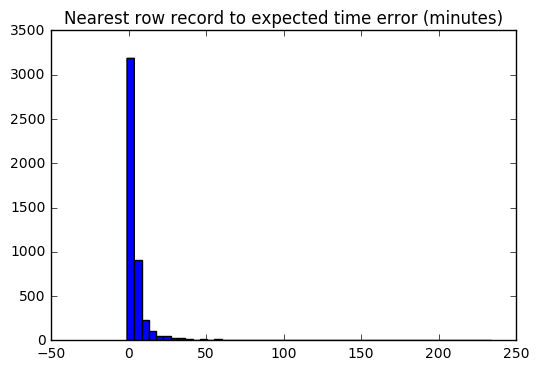

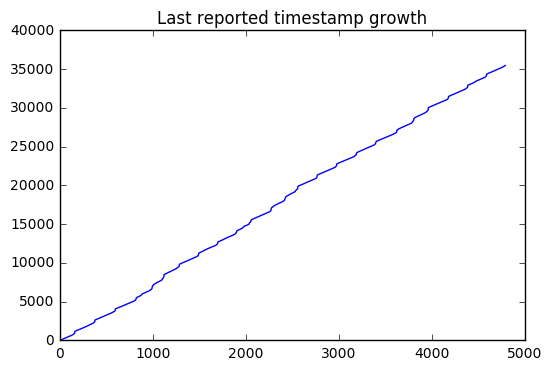

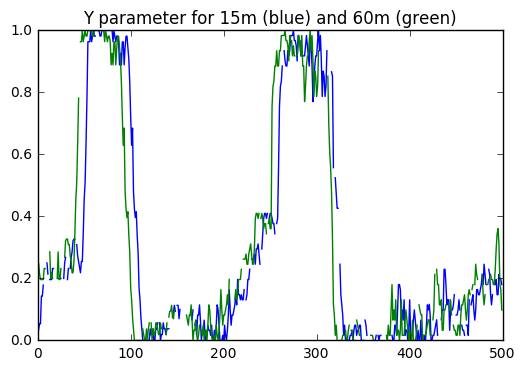

520
522
523
524
525
526
527
528
529
530
531
532
533
534
536
537
539
540
546
2000
2001
2002
2003
2004
2005
2006
2008
2009
2010
2012
2017
2021
2022
2023
3002
3016
3041
3042
3043
3044
3046
3047
3048
3049
3050
3052
3053
3054
3055
3056
3057
3058
3059
3060
3061
3062
3063
3064
3065
3066
3067
3068
3069
3070
3071
3072
3073
3074
3075
3076
3077
3078
3079
3080
3081
3082
3083
3084
3085
3086
3087
3088
3089
3090
3091
3092
3093
3094
3095
3096
3098
3099
3100
3101
3102
3103
3105
3106
3107
3108
3109
3110
3111
3112
3113
3114
3115
3116
3117
3118
3119
3120
3121
3122
3123
3124
3125
3126
3127
3128
3129
3131
3132
3134
3135
3137
3139
3140
3141
3142
3143
3144
3145
3146
3147
3148
3150
3151
3152
3153
3155
3156
3157
3158
3159
3160
3161
3162
3163
3164
3165
3166
3167
3168
3169
3170
3171
3172
3173
3175
3176
3177
3178
3179
3180
3183
3184
3185
3186
3187
3188
3189
3190
3191
3192
3193
3194
3195
3196
3197
3198
3199
3200
3201
3202
3203
3205
3206
3207
3209
3210
3211
3212
3213
3214
3215
3216
3217
3220
3221
3223
3224
3225
3226

In [131]:
labels = [
    (10, '10m'),
    (15, '15m'),
    (30, '30m'),
    (45, '45m'),
    (60, '60m'),
    (90, '90m'),
    (120, '120m'),
]

np.set_printoptions(suppress=False)

minutes_before_limit = 1
minutes_after_limit = 5

for station_id, group in bikes.groupby(['station_id']):
    gc = group.copy()
    d = lookup[station_id]
    timestamps = group['last_reported'].as_matrix()

    for minutes, name in labels:
        # I want to find rows with timestamp at least X minutes in the future
        # Example: To find the "15 minute ahead row", find the earliest row at least 14 minutes ahead
        look = group['last_reported'] + np.timedelta64(minutes - minutes_before_limit, 'm')

        # Indices of rows that satisfy the above
        ins = np.searchsorted(d['times'], look)
        assert (np.diff(ins) >= 0).all() # Assert indices are increasing

        # Get the actual timestamps of the nearest records, and the occupancy value
        future_indices = ins[ins < len(timestamps)]
        future_timestamps = timestamps[future_indices]
        future_y = d['y'].as_matrix()[future_indices]

        # What's the expected timestamp, and how far off is the real timestamp
        expected = timestamps[:len(future_timestamps)] + np.timedelta64(minutes, 'm')
        error = (future_timestamps - expected)/np.timedelta64(1, 'm')

        # Turn all rows that are outside the range to -1.0 (invalid value)
        future_y_filtered = future_y[:]
        future_y_filtered[error > minutes_after_limit] = -1.0

        gc['y_' + name] = np.concatenate(
            [future_y_filtered, [-1.0] * (len(gc) - len(future_y_filtered))], axis=0)
    
    gc.to_csv('per_station/' + str(station_id) + '.csv')
    print(station_id)

    if station_id == 519:
        print(gc.columns)

        #dif = lr_ins - group['last_reported']
        print(future_indices)

        print('Error: {} +/- {}'.format(error.mean(), error.std()))
        print('Range: {} to {}'.format(error.min(), error.max()))
        print('Error > {} mins: {} out of {}'.format(
                minutes_after_limit, sum(error > minutes_after_limit), len(error)))

        plt.figure()
        plt.hist(error, 50)
        plt.title('Nearest row record to expected time error (minutes)')
        plt.show()

        plt.figure()
        #plt.plot(np.diff(gins)/np.timedelta64(1, 'm'))
        plt.plot((timestamps - timestamps[0]) / np.timedelta64(1, 'm'))
        plt.title('Last reported timestamp growth')
        plt.show()

        plt.figure()
        ff1 = gc['y_15m'].as_matrix()[:]
        ff2 = gc['y_60m'].as_matrix()[:]
        ff1[ff1 < 0] = None
        ff2[ff2 < 0] = None
        plt.plot(ff1[:500], 'b')
        plt.plot(ff2[:500], 'g')
        plt.title('Y parameter for 15m (blue) and 60m (green)')
        plt.show()
    #print(dif)